In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors
from tqdm import tqdm

from sklearn import metrics
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
EMBEDDING_FILES = [
    '/content/drive/MyDrive/Data/crawl-300d-2M.vec',
    '/content/drive/MyDrive/Data/glove.840B.300d.txt'
]

In [ ]:
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target_boolean'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

In [ ]:
def load_embeddings(path):
    #each line in the file looks like 
    # apple 0.3 0.4 0.5 0.6 ...
    # that is a word followed by 300 float numbers

    with open(path) as f:
        #return dict(get_coefs(*line.strip().split(' ')) for line in f)
        return dict(get_coefs(*o.strip().split(" ")) for o in tqdm(f))

In [ ]:
#def build_matrix(word_index, path):
#    embedding_index = KeyedVectors.load(path, mmap='r')
#    embedding_matrix = np.zeros((len(word_index) + 1, 300))
#    for word, i in word_index.items():
#        for candidate in [word, word.lower()]:
#            if candidate in embedding_index:
#                embedding_matrix[i] = embedding_index[candidate]
#                break
#    return embedding_matrix

def build_matrix(word_index, path):
    #path: a path that contains embedding matrix
    #word_index is a dict of the form ('apple': 123, 'banana': 349, etc)
    # that means word_index[word] gives the index of the word
    # word_index was built from all commment_texts

    #we will construct an embedding_matrix for the words in word_index
    #using pre-trained embedding word vectors from 'path'

    embedding_index = load_embeddings(path)

    #embedding_matrix is a matrix of len(word_index)+1  x 300
    embedding_matrix = np.zeros((len(word_index) + 1, 300))

    # word_index is a dict. Each element is (word:i) where i is the index
    # of the word
    for word, i in word_index.items():
        try:
            #RHS is a vector of 300d
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [ ]:
def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [ ]:
#train_df = pd.read_csv('/content/drive/MyDrive/Data/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
#test_df = pd.read_csv('/content/drive/MyDrive/Data/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

raw_train = pd.read_csv('/content/drive/MyDrive/Data/jigsaw-unintended-bias-in-toxicity-classification/train.csv')

train_df, test_df = model_selection.train_test_split(raw_train, test_size=0.2)

In [ ]:
x_train = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values
y_aux_train = train_df[AUX_COLUMNS].values
x_test = test_df[TEXT_COLUMN].astype(str)
y_test = test_df[TARGET_COLUMN].values

In [ ]:
for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

In [ ]:
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [ ]:
sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)
sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)
sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5
sample_weights /= sample_weights.mean()

In [ ]:
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

1999996it [02:19, 14324.80it/s]
2196017it [02:30, 14618.48it/s]


In [ ]:
checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)

2821/2821 - 836s - loss: 0.5292 - dense_2_loss: 0.4217 - dense_3_loss: 0.1075 - 836s/epoch - 296ms/step
2821/2821 - 827s - loss: 0.5099 - dense_2_loss: 0.4073 - dense_3_loss: 0.1026 - 827s/epoch - 293ms/step
2821/2821 - 827s - loss: 0.5040 - dense_2_loss: 0.4024 - dense_3_loss: 0.1016 - 827s/epoch - 293ms/step
2821/2821 - 826s - loss: 0.4993 - dense_2_loss: 0.3984 - dense_3_loss: 0.1009 - 826s/epoch - 293ms/step
2821/2821 - 828s - loss: 0.5294 - dense_6_loss: 0.4217 - dense_7_loss: 0.1076 - 828s/epoch - 294ms/step
2821/2821 - 824s - loss: 0.5102 - dense_6_loss: 0.4075 - dense_7_loss: 0.1027 - 824s/epoch - 292ms/step
2821/2821 - 825s - loss: 0.5043 - dense_6_loss: 0.4026 - dense_7_loss: 0.1016 - 825s/epoch - 293ms/step
2821/2821 - 824s - loss: 0.4997 - dense_6_loss: 0.3987 - dense_7_loss: 0.1010 - 824s/epoch - 292ms/step


In [ ]:
predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

In [ ]:
submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'prediction': predictions
})

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
MODEL_NAME = 'my_model'

In [ ]:
test_df[MODEL_NAME] = predictions

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
498523,False,False,False,False,False,False,False,False,False
521700,False,False,False,False,False,False,False,False,False
1791788,False,False,False,False,False,False,False,False,False
1504490,False,False,False,False,False,False,False,True,False
213338,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
1118415,False,False,False,False,False,False,False,False,False
1008939,False,False,False,False,False,False,False,False,False
553598,False,False,False,False,False,False,False,False,False
1104904,False,False,False,False,False,False,False,False,False


In [ ]:
test_df[TARGET_COLUMN] = np.where(test_df[TARGET_COLUMN] >= 0.5, True, False)

In [ ]:
test_df.describe()

,id,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,my_model
count,3.609750e+05,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,80888.000000,80888.000000,80888.000000,80888.000000,...,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000,360975.000000
mean,3.735097e+06,0.004631,0.013951,0.022782,0.081333,0.009214,0.012008,0.003226,0.001754,0.033747,...,281205.756750,0.277354,0.043967,0.109010,2.454901,0.584866,0.006661,1.469515,8.790958,0.141563
std,2.445544e+06,0.022948,0.064738,0.078843,0.176423,0.049213,0.087309,0.050081,0.024938,0.166166,...,103955.511321,1.050266,0.247082,0.448369,4.777611,1.857185,0.045557,19.298208,43.793605,0.195715
min,5.986300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.001473
25%,7.966190e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,160110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.014292
50%,5.221180e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,331941.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.042550
75%,5.768046e+06,0.000000,0.000000,0.000000,0.093178,0.000000,0.000000,0.000000,0.000000,0.000000,...,366111.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,6.000000,0.187810
max,6.334009e+06,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,399531.000000,102.000000,21.000000,15.000000,300.000000,116.000000,1.000000,1842.000000,3623.000000,0.952761


In [ ]:
for column in IDENTITY_COLUMNS:
    test_df[column] = np.where(test_df[column] >= 0.5, True, False)

In [ ]:
SUBGROUP_AUC = 'Subgroup_AUC'
BPSN_AUC = 'BPSN_AUC'  # stands for background positive, subgroup negative
BNSP_AUC = 'BNSP_AUC'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('Subgroup_AUC', ascending=True)

In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(test_df, IDENTITY_COLUMNS, MODEL_NAME, TARGET_COLUMN)

In [ ]:
bias_metrics_df

,subgroup,subgroup_size,Subgroup_AUC,BPSN_AUC,BNSP_AUC
2,homosexual_gay_or_lesbian,2216,0.849795,0.922098,0.938024
7,white,5014,0.865027,0.927466,0.942403
6,black,2928,0.869129,0.922117,0.944991
5,muslim,4232,0.874827,0.939179,0.935902
4,jewish,1482,0.903083,0.960673,0.922801
8,psychiatric_or_mental_illness,940,0.923689,0.941196,0.956286
1,female,10682,0.930909,0.969788,0.930703
0,male,8892,0.933302,0.964524,0.938595
3,christian,8121,0.938338,0.977236,0.917969


In [ ]:
test_df['target_boolean'] = test_df['target']

In [ ]:
test_df['my_model_boolean'] = np.where(test_df['my_model'] >= 0.5, True, False)

In [ ]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TARGET_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    print("Avg bias score: "+ str(bias_score))
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [ ]:
FINAL_SCORE = get_final_metric(bias_metrics_df, calculate_overall_auc(test_df, MODEL_NAME))

Avg bias score: 0.9256833325901176


In [ ]:
print(FINAL_SCORE)

0.935659222369745


In [ ]:
calculate_overall_auc(test_df, MODEL_NAME)

0.965586891708627

In [ ]:
power_mean(bias_metrics_df[SUBGROUP_AUC], -5)

0.8951562350842043

In [ ]:
power_mean(bias_metrics_df[BPSN_AUC], -5)

0.9458670288191491

In [ ]:
power_mean(bias_metrics_df[BNSP_AUC], -5)

0.9360267338669996

In [ ]:
metrics_list = [['Overall_AUC', 0.965586891708627], ['Subgroup_AUC', 0.8951562350842043], ['BPSN_AUC', 0.9458670288191491], ['BNSP_AUC', 0.9360267338669996], ['Mean of bias AUCs', 0.9256833325901176], ['FINAL SCORE', 0.935659222369745]]

In [ ]:
metrics_df = pd.DataFrame(metrics_list, columns=['Metric', 'Score'])

In [ ]:
metrics_df

,Metric,Score
0,Overall_AUC,0.965587
1,Subgroup_AUC,0.895156
2,BPSN_AUC,0.945867
3,BNSP_AUC,0.936027
4,Mean of bias AUCs,0.925683
5,FINAL SCORE,0.935659


In [ ]:
fpr, tpr, _ = metrics.roc_curve(test_df[TARGET_COLUMN],  test_df[MODEL_NAME])
auc = metrics.roc_auc_score(test_df[TARGET_COLUMN],  test_df[MODEL_NAME])

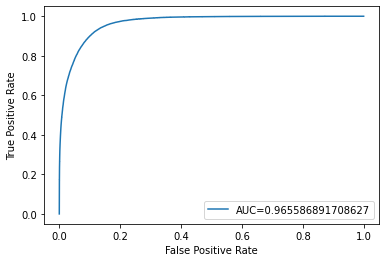

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(test_df[TARGET_COLUMN],  test_df['my_model_boolean'])

print(cf_matrix)

[[319794  12254]
 [  7861  21066]]


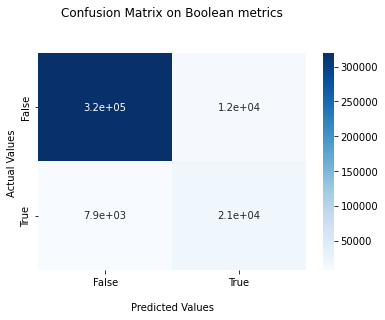

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix on Boolean metrics\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

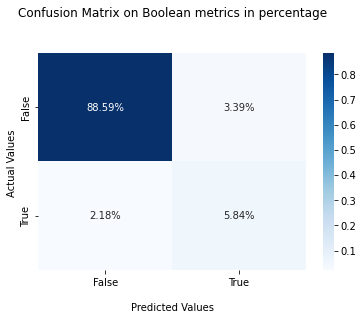

In [ ]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix on Boolean metrics in percentage\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_df[TARGET_COLUMN],  test_df['my_model_boolean'])

0.944275919384999

In [ ]:
# Importing all necessary libraries
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
print(f"Precision Score of the classifier is: {precision_score(test_df[TARGET_COLUMN],  test_df['my_model_boolean'])}")

Precision Score of the classifier is: 0.6322328931572629


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import recall_score

# Calculating the recall score of classifier
print(f"Recall Score of the classifier is: {recall_score(test_df[TARGET_COLUMN],  test_df['my_model_boolean'])}")

Recall Score of the classifier is: 0.728246966501884


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
print(f"F1 Score of the classifier is: {f1_score(test_df[TARGET_COLUMN],  test_df['my_model_boolean'])}")

F1 Score of the classifier is: 0.6768518964769387


In [ ]:
cf_list = [['Accuracy', 0.944275919384999], ['Precision', 0.6322328931572629], ['Recall', 0.728246966501884], ['F1 Score', 0.6768518964769387]]

In [ ]:
cf_df = pd.DataFrame(cf_list, columns=['Metric', 'Score'])

In [ ]:
cf_df

,Metric,Score
0,Accuracy,0.944276
1,Precision,0.632233
2,Recall,0.728247
3,F1 Score,0.676852


In [ ]:
final_metric_list = [['Overall ROC_AUC score', 0.965586891708627], ['Accuracy based on Confusion matrix', 0.944275919384999], ['Final score on Kaggle metrics (Bias AUCs)', 0.935659222369745]]

In [ ]:
final_metric_df = pd.DataFrame(final_metric_list, columns=['Metric', 'Score'])

In [ ]:
final_metric_df

,Metric,Score
0,Overall ROC_AUC score,0.965587
1,Accuracy based on Confusion matrix,0.944276
2,Final score on Kaggle metrics (Bias AUCs),0.935659
